In [5]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [6]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean

In [492]:
rf_rates = dl.pull('RFrates').divide(100)
daily_rf_rates = (rf_rates + 1).pow(1/261)-1
daily_rf_rates = daily_rf_rates.resample('B').ffill()

monthly_rf_rates = (rf_rates + 1).pow(1/12)-1

rf_rate_matrix = pd.DataFrame(0, index=bond_return_index.index, 
                              columns=bond_return_index.columns)
rf_rate_matrix_monthly = pd.DataFrame(0, index=monthly_rf_rates.index, 
                              columns=bond_return_index.columns)
for country in country_codes:
    rf_rate_matrix[country] = daily_rf_rates
    rf_rate_matrix_monthly[country] = monthly_rf_rates

# Helper Functions

**Profit and Loss Curve Function**

In [685]:
def pnl_curve(signals):
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix
    lagged_returns = bond_daily_returns.shift(-1)

    sig_returns = (lagged_returns * daily_signals)
    cum_sig_returns = (1+sig_returns).cumprod()
    sig_pct = (cum_sig_returns-1)*100
    
    for country in country_codes:
        sig_pct[country].dropna().rolling(60).mean().plot()
        plt.title(country + ' Returns')
        plt.ylabel('Return Percentage (%)')
        plt.show()
    
    sig_pct.sum(axis=1).plot()
    plt.title('Total Returns')
    plt.ylabel('Return Percentage (%)')
    plt.show()

**Sharpe Ratio Function**

In [296]:
def sharpe_ratio(signals):
    
    daily_signals = signals.resample("B").ffill()
    
    bond_daily_returns = bond_return_index.pct_change() - rf_rate_matrix 
    lagged_returns = bond_daily_returns.shift(-1)

    returns = (lagged_returns * daily_signals) 
    
    country_SR = pd.Series(float(), index=country_codes)
    
    for country in country_codes:
        country_returns = returns[country].dropna()
        gmean_returns = gmean(1+country_returns)
        overall_return = (gmean_returns)**(261)-1
        overall_risk = country_returns.std()*np.sqrt(261)
        country_SR[country] = overall_return/overall_risk
    
    gmean_returns = gmean(1+returns.sum(axis=1))
    overall_return = (gmean_returns)**(261)-1
    overall_risk = returns.sum(axis=1).std()*np.sqrt(261)
    
    country_SR['AVERAGE'] = country_SR.mean()
    
    return(country_SR)

**Correlation with Long-Only Signals**

In [500]:
def corr_with_long(signals):
    # look at monthly
    monthly_signals = signals.resample("M").ffill()
    long_signals = pd.DataFrame(1, index=monthly_signals.index,
                                columns=monthly_signals.columns)
    
    bond_monthly_returns = bond_return_index.resample('M').mean().pct_change() - rf_rate_matrix_monthly
    lagged_returns = bond_monthly_returns.shift(-1)
    
    sig_returns = lagged_returns * monthly_signals
    long_returns = lagged_returns * long_signals
    
    corr = sig_returns.corrwith(long_returns)
    corr['AVERAGE'] = corr.mean()
    return(corr)

# Curve Height Indicator

When using curve height as an indicator, it's most important to judge the different curve heights relative to other countries in a given year, since curve height is representative of international opportunity cost and will drive flows between different countries. While curve height also has an effect on domestic opportunity cost (i.e. if the curve height for bonds is low in the US, investors may instead choose to put their money in a different asset class, and the lack of demand for bonds will drive down prices and result in negative returns), I chose to focus most on the cross-country effect of curve height, since we want to maximize returns in all 10 of the given countries, rather than focus on just one. 

Secondly, curve height should be measured based on its value relative to other countries, rather than its change over time. Our best indicator will tell us where a country's curve height lies relative to other countries, rather than whether it is increasing or decreasing, because its relative value is what will drive investors to buy or sell in different countries, causing prices to either rise or fall in the future.

To calculate our indicator, first, we'll calculate curve height as an average of long and short rates.

In [11]:
long_rates = dl.pull('LongRates')
short_rates = dl.pull('ShortRates')

curve_height = (long_rates+short_rates)/2
curve_height.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.4490,-0.5615,0.5040,0.2885,-0.2510,0.9795,-0.0635,-0.4605,0.2145,0.4345
2020-05,0.5590,-0.6725,0.4275,0.3120,-0.3555,1.1510,-0.0920,-0.5950,0.1415,0.4210
2020-06,0.5865,-0.5230,0.4090,0.0900,-0.2650,0.9060,-0.0780,-0.5710,0.1155,0.4100
2020-07,0.6020,-0.5300,0.4065,0.0090,-0.3270,0.7250,-0.0450,-0.5235,0.0750,0.4230
2020-08,0.5745,-0.6105,0.3655,-0.0185,-0.4105,0.5265,-0.0540,-0.6630,0.0130,0.3390


As discussed above, relative curve heights are important when determining opportunity cost between different countries. To relativize the curve heights in each year, I calculated a simple moving global average that incorporates values from the last seven years (the average length of a typical short-term business cycle) and subtracted it from each value, to show how each country's curve height compared to the global average (in absolute terms). I then standardized within countries so that the mean and standard deviation within each country was 0 and 1, respectively.


In [320]:
# Take 7-year global average
global_avgs = curve_height.mean(axis=1)
CH_sma_7Y = global_avgs.rolling(84).mean()

# Subtract from each value
relative_CH = curve_height.sub(CH_sma_7Y,axis=0)

# Standardize in relation to a country's history over time
standardized_CH = (relative_CH-relative_CH.mean())/relative_CH.std()
standardized_CH.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,-0.821231,0.106337,0.098094,-0.337693,-0.078767,-0.108462,1.574907,1.087732,-0.236515,0.410195
2020-05,-0.745524,0.021215,0.038854,-0.312085,-0.167055,-0.002650,1.566293,0.975522,-0.298660,0.411217
2020-06,-0.718131,0.169005,0.038023,-0.448952,-0.060697,-0.131830,1.586093,1.014530,-0.307584,0.416697
2020-07,-0.696403,0.180766,0.055096,-0.489603,-0.101713,-0.223132,1.619456,1.078054,-0.329130,0.444203
2020-08,-0.700606,0.127777,0.035505,-0.494241,-0.163604,-0.324221,1.626702,0.966629,-0.373314,0.391813


Let's connect our standardized curve height value directly to bond returns. If a country's relative curve height is higher than average, I would expect investors to buy bonds in that country due to higher yields (and thus cheaper bonds). This increased demand would drive prices down, resulting in positive returns for investors in the next year. Alternatively, a country with a low relative curve height will drive investors to sell bonds in that country due to high prices, driving prices down and resulting in negative returns for investors in the next year.

To compare spot relative curve heights to returns over the coming year, I shifted quarterly bond returns forward a year and took the rolling mean over the past 4 quarters: this essentially conncets the current relative curve height to the average returns in the next year for an investor who buys the bond today. As shown in the graphs below, our reasoning is generally correct for most countries: there is a direct relationship between relative curve height and returns over the next year.

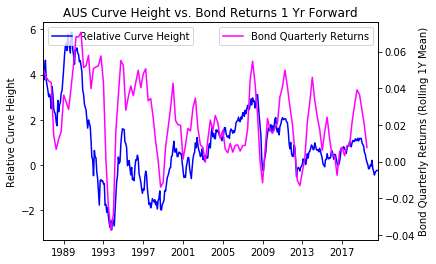

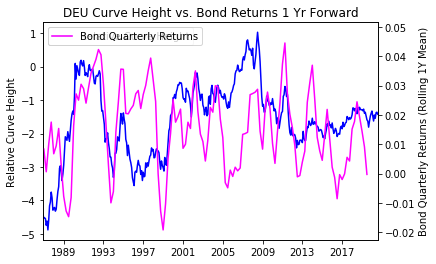

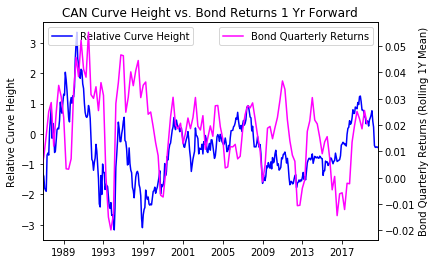

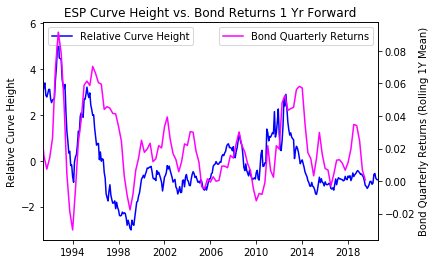

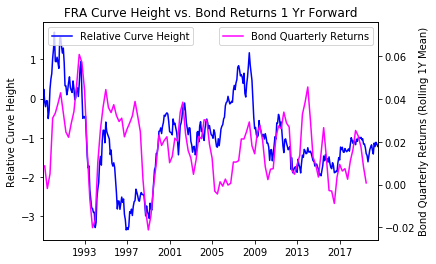

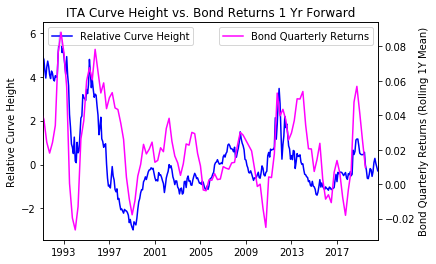

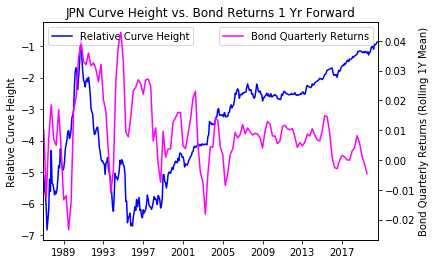

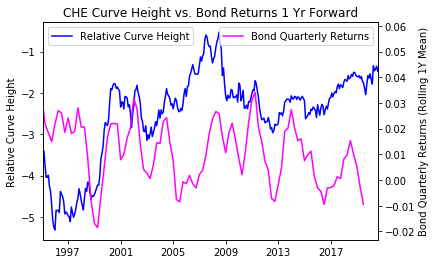

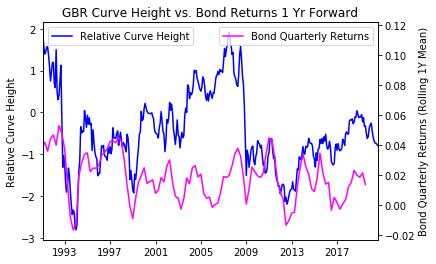

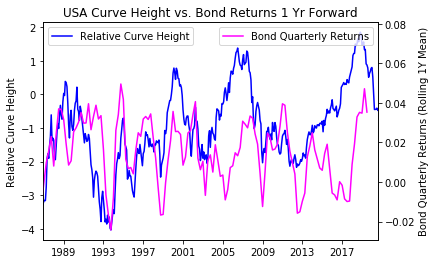

In [1073]:
bond_quarterly_returns = bond_return_index.resample('Q').mean().pct_change()

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Relative Curve Height'
    ax1.plot(relative_CH[country].to_timestamp(), color='blue', 
                 label = ax1_label)
    ax1.set_ylabel(ax1_label)
    ax1.legend(loc=2)
    ax2_label = 'Bond Quarterly Returns'
    ax2.plot(bond_quarterly_returns[country].shift(-4).to_timestamp()
         .rolling(4).mean(),color='magenta', label = ax2_label)
    ax2.set_ylabel('Bond Quarterly Returns (Rolling 1Y Mean)')
    ax2.legend(loc='best')
    
    
    plt.xlim(str(relative_CH[country].dropna().index.min()), 
            str(relative_CH[country].dropna().index.max()))
    plt.title(country + ' Curve Height vs. Bond Returns 1 Yr Forward')
    plt.show()

To create the signals, I divided the standardized curve heights by 2, and clipped them from -1 to 1. This maps all values greater than 2 or less than -2 to 1 or -1, respectively, and maps other values linearly between them: for example, a value of 0.5 maps to 0.25. I did this because I wanted to only go 100% long or 100% short when curve height is drastically above or below average: 2 standard deviations above or below, which happens about 5% of the time. This gives a sharpe ratio of 0.259, on average.

In [1131]:
CH_signals = standardized_CH.divide(2).clip(-1,1)
sharpe_ratio(CH_signals)

country
AUS        0.264365
DEU        0.386836
CAN        0.229559
ESP        0.336929
FRA        0.163600
ITA        0.435300
JPN        0.101062
CHE        0.019309
GBR        0.308459
USA        0.347127
AVERAGE    0.259255
dtype: float64

I then converted all signals with an absolute value less than 0.25 to 0. This is because with short and long rates constantly changing, there is bound to be a lot of noise in this signal. I wanted to ensure that my trading signal did not overreact to small changes in curve height that may not actually trigger substantial changes in bond returns. The threshold of 0.25 gets rid of any signals for curve height values within 0.5 standard deviations of the mean, which could have just occured by chance or because of random noise, and improves the sharpe ratio to 0.277 on average.

In [1132]:
CH_signals[np.abs(CH_signals)<.25] = 0
CH_signals = CH_signals.rolling(3).mean()
sharpe_ratio(CH_signals)

country
AUS        0.342564
DEU        0.451116
CAN        0.287391
ESP        0.536686
FRA        0.198199
ITA        0.560930
JPN        0.200465
CHE       -0.022744
GBR        0.380301
USA        0.421998
AVERAGE    0.335691
dtype: float64

The returns for each country are plotted below. Something weird happened close to 2000, which I'll look into later.

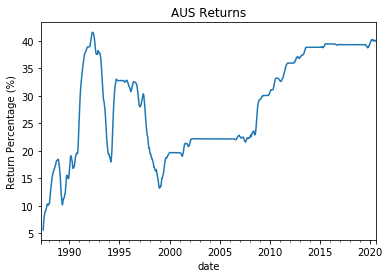

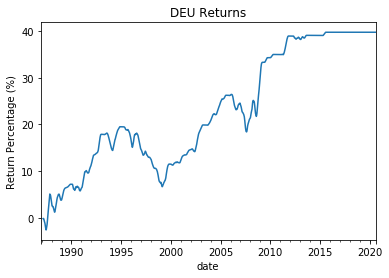

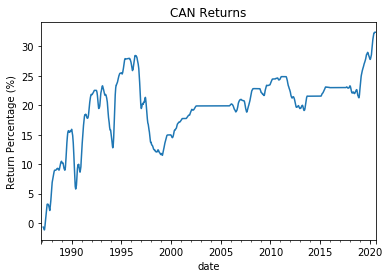

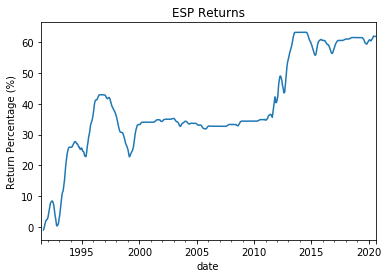

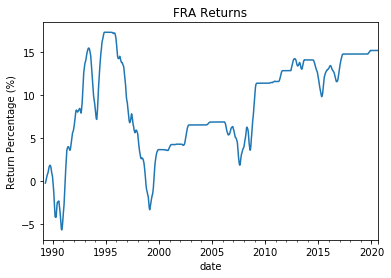

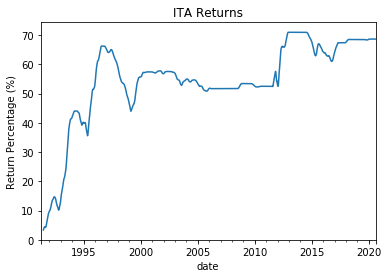

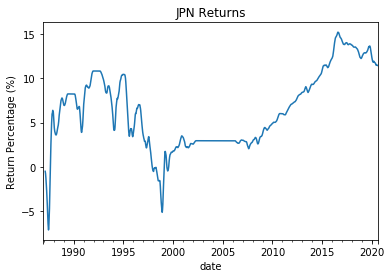

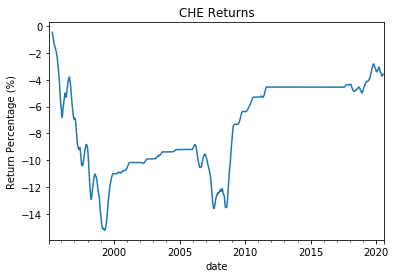

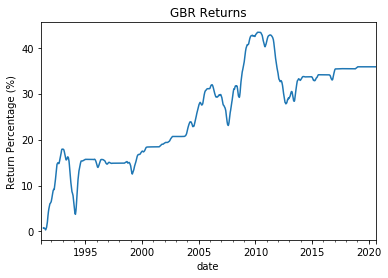

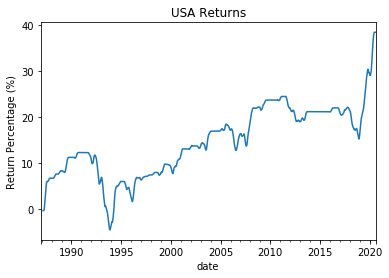

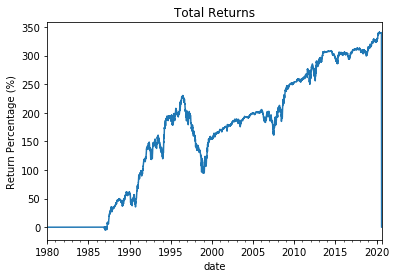

In [973]:
pnl_curve(CH_signals)

Finally, we want to compare the returns generated by this signal to the returns from a long-only signal. The average correlation is -0.02, which is fairly low.

In [975]:
corr_with_long(CH_signals)

country
AUS       -0.020537
DEU       -0.022944
CAN       -0.000591
ESP        0.294506
FRA        0.018828
ITA        0.335692
JPN       -0.575695
CHE       -0.069076
GBR       -0.133117
USA       -0.103011
AVERAGE   -0.027595
dtype: float64

# Change in GDP

Change in Real GDP is a good indicator on how the economy is doing overall, which can give investors a hint about future bond returns. When growth is higher than average, the economy is doing well, and lots of people are borrowing and spending money. We can assume that generally, a high demand for borrowing would leave to increased interest rates. As the economy heats up, the 

In [1072]:
RGDP = dl.pull("GDP/Real")
RGDP_QOQ = RGDP.pct_change()
RGDP_QOQ.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,0.005546,0.003093,0.002792,0.004047,0.001579,0.000052,0.000038,0.004400,0.005116,0.006369
2019Q4,0.005209,-0.000187,0.001397,0.004104,-0.001856,-0.002286,-0.018566,0.003379,-0.000001,0.005862
2020Q1,-0.003060,-0.020186,-0.021089,-0.052090,-0.059396,-0.053805,-0.005586,-0.026071,-0.021872,-0.012627
2020Q2,0.000000,-0.100915,0.000000,-0.184840,-0.138151,-0.123579,0.000000,0.000000,0.000000,-0.094947
2020Q3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [435]:
global_avg_1Y = RGDP_QOQ.rolling(4).mean().mean(axis=1)

# how is it doing relative to the global avg over the past year?
relative_growth = (RGDP_QOQ.sub(global_avg_1Y, axis=0))

# how does that relative performance compare to the country's relative performance
# over the past 7 years (biz cycle)?
standardized_rel_growth = (relative_growth.rolling(28).
                           mean()-relative_growth)/relative_growth.rolling(28).std()

standardized_rel_growth.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,-0.049572,0.039035,0.341381,0.165975,0.460590,0.230537,0.345114,-0.104061,-0.331200,-0.279224
2019Q4,-0.296526,0.595567,0.429977,-0.005488,1.302347,0.914352,2.438509,-0.069151,1.195511,-0.357964
2020Q1,-0.249494,2.739091,2.848431,4.888745,4.907237,4.963611,-0.300591,3.892224,3.962012,2.378498
2020Q2,-4.274271,4.846100,-3.158132,4.875071,4.592448,4.592257,-2.762808,-3.317249,-3.702290,4.944622
2020Q3,-3.304413,-1.600318,-2.718520,-0.856999,-1.196611,-1.413745,-2.468936,-2.806771,-3.056482,-1.557512


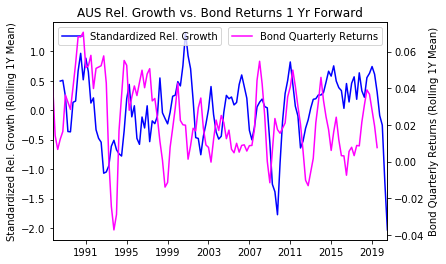

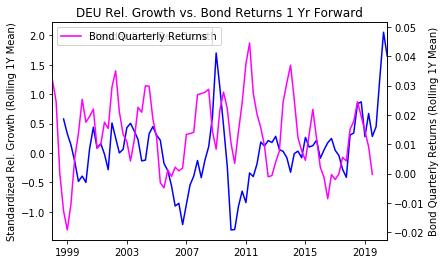

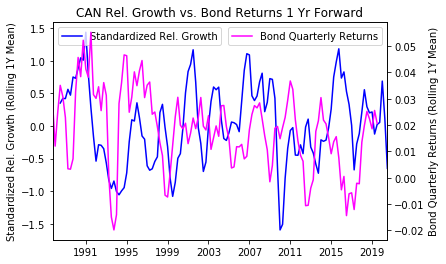

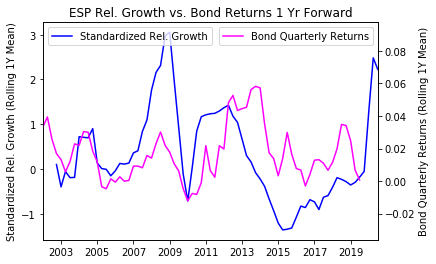

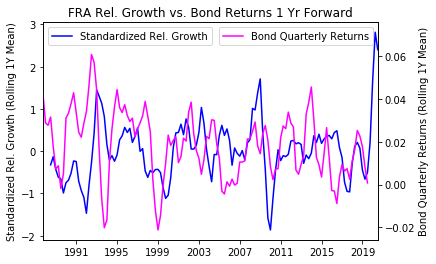

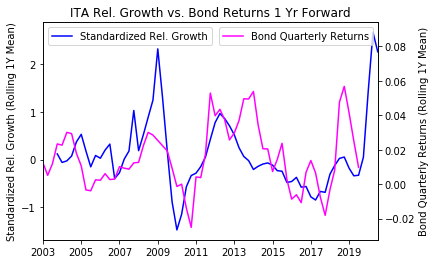

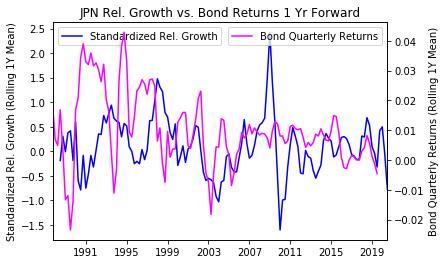

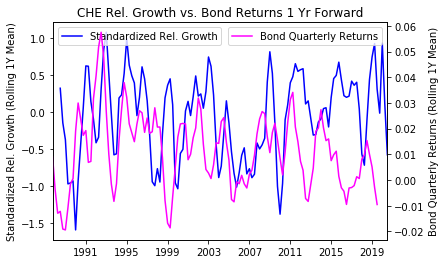

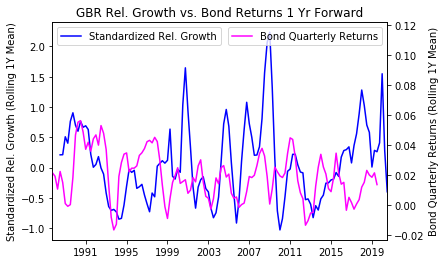

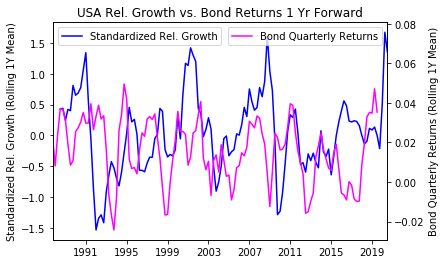

In [1068]:
bond_quarterly_returns = bond_return_index.resample('Q').mean().pct_change()
shifted_quarterly_returns = bond_quarterly_returns.shift(-4)

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1_label = 'Standardized Rel. Growth'
    ax1.plot(standardized_rel_growth[country].rolling(4).mean().dropna()
             .to_timestamp(), color='blue', label = ax1_label)
    ax1.set_ylabel('Standardized Rel. Growth (Rolling 1Y Mean)')
    ax1.legend(loc=2)
    ax2_label = 'Bond Quarterly Returns'
    ax2.plot(shifted_quarterly_returns[country].to_timestamp()
         .rolling(4).mean(),color='magenta', label = ax2_label)
    ax2.set_ylabel('Bond Quarterly Returns (Rolling 1Y Mean)')
    ax2.legend(loc='best')
    
    plt.xlim(str(standardized_rel_growth[country].dropna().index.min()), 
            str(standardized_rel_growth[country].dropna().index.max()))
    plt.title(country + ' Rel. Growth vs. Bond Returns 1 Yr Forward')
    plt.show()

In [1085]:
GDP_signals = standardized_rel_growth.divide(2).clip(-1,1)
GDP_signals[np.abs(GDP_signals)<.25] = 0
GDP_signals = GDP_signals.rolling(2).mean()
sharpe_ratio(GDP_signals)

country
AUS        0.229375
DEU        0.327141
CAN        0.204512
ESP       -0.037411
FRA        0.518990
ITA        0.165461
JPN        0.374739
CHE        0.483760
GBR        0.201448
USA        0.391911
AVERAGE    0.285993
dtype: float64

In [917]:
corr_with_long(GDP_signals)

country
AUS       -0.149158
DEU        0.154670
CAN       -0.006630
ESP        0.426415
FRA        0.095517
ITA        0.413626
JPN        0.077592
CHE        0.000825
GBR        0.094656
USA        0.212434
AVERAGE    0.131995
dtype: float64

# Combining Indicators

**Sharpe-Weighted Combination by Country**

In [1163]:
print(sharpe_ratio(GDP_signals))
print(sharpe_ratio(CH_signals))

country
AUS        0.229375
DEU        0.327141
CAN        0.204512
ESP       -0.037411
FRA        0.518990
ITA        0.165461
JPN        0.374739
CHE        0.483760
GBR        0.201448
USA        0.391911
AVERAGE    0.285993
dtype: float64
country
AUS        0.342564
DEU        0.451116
CAN        0.287391
ESP        0.536686
FRA        0.198199
ITA        0.560930
JPN        0.200465
CHE       -0.022744
GBR        0.380301
USA        0.421998
AVERAGE    0.335691
dtype: float64


In [1152]:
GDP_signals = GDP_signals.resample('M').ffill()

def generate_signals():
    signals = pd.DataFrame(0, index=CH_signals.index, columns=CH_signals.columns)
    for country in country_codes:
        GDP_sharpe = sharpe_ratio(GDP_signals)[country]
        CH_sharpe = sharpe_ratio(CH_signals)[country]
    
        if GDP_sharpe < 0:
            GDP_sharpe = 0
        if CH_sharpe < 0:
            CH_sharpe = 0
        
        GDP_weight = GDP_sharpe/(GDP_sharpe+CH_sharpe)
        CH_weight = CH_sharpe/(GDP_sharpe+CH_sharpe)
    
        signals[country] = GDP_weight*GDP_signals[country] + CH_weight*CH_signals[country]
    return(signals)
        

In [1153]:
signals = generate_signals()
sharpe_ratio(signals)

country
AUS        0.306453
DEU        0.669669
CAN        0.273626
ESP        0.335883
FRA        0.532719
ITA        0.240569
JPN        0.470694
CHE        0.242589
GBR        0.384545
USA        0.470102
AVERAGE    0.392685
dtype: float64

**Amplify Signals that Agree in Direction**

In [1159]:
signals = generate_signals()
signals[GDP_signals*CH_signals > 0] = (signals*3).clip(-1,1)
sharpe_ratio(signals)

country
AUS        0.275415
DEU        0.735855
CAN        0.244470
ESP        0.284199
FRA        0.529712
ITA        0.240194
JPN        0.465714
CHE        0.295755
GBR        0.286119
USA        0.496460
AVERAGE    0.385389
dtype: float64

**Dampen Signals that Disagree in Direction**

In [1160]:
signals = generate_signals()
signals[GDP_signals*CH_signals < 0] = (signals/2).clip(-1,1)
sharpe_ratio(signals)

country
AUS        0.359937
DEU        0.744215
CAN        0.271651
ESP        0.340508
FRA        0.540239
ITA        0.251562
JPN        0.447222
CHE        0.300489
GBR        0.362759
USA        0.453851
AVERAGE    0.407243
dtype: float64

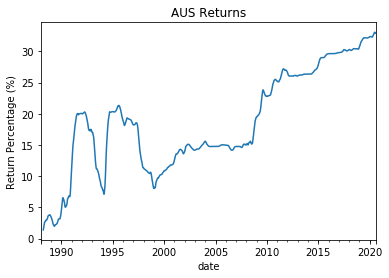

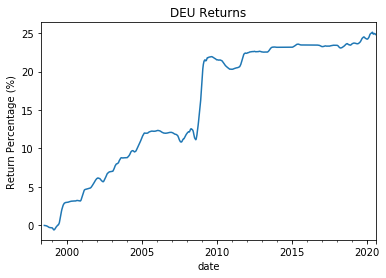

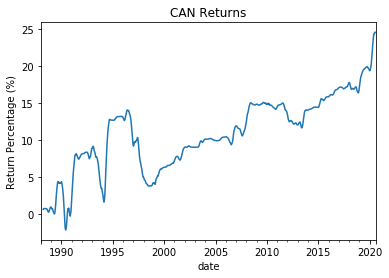

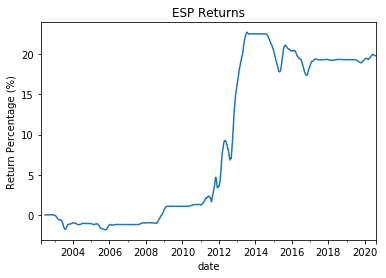

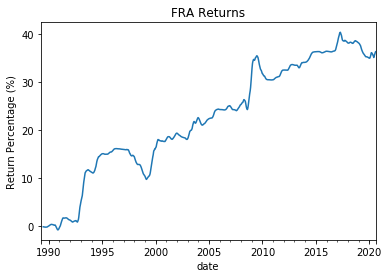

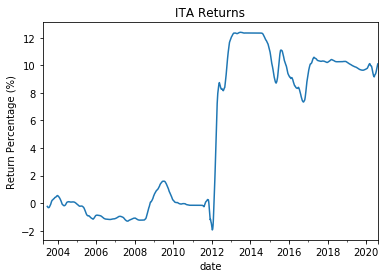

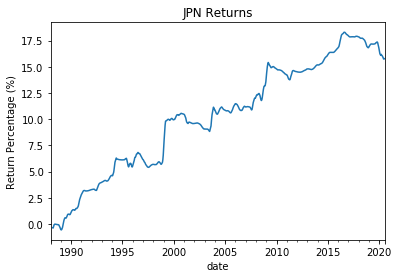

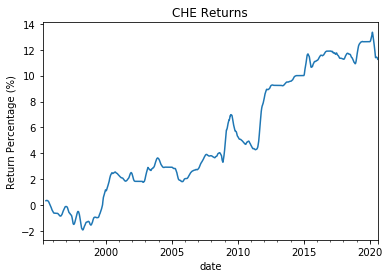

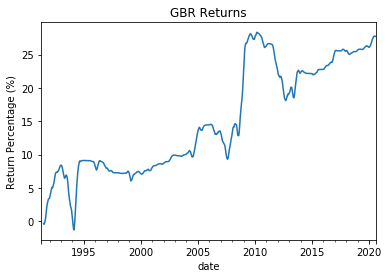

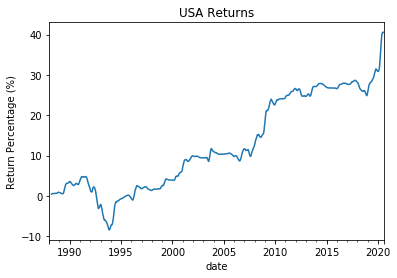

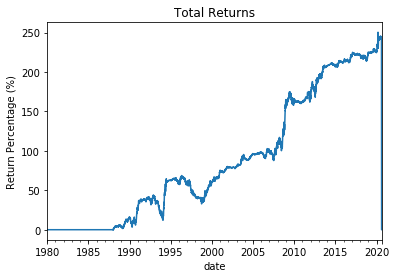

In [1161]:
pnl_curve(signals)

In [1162]:
corr_with_long(signals)

country
AUS       -0.115706
DEU        0.389833
CAN       -0.007218
ESP        0.254654
FRA        0.124716
ITA        0.284153
JPN       -0.247297
CHE        0.075798
GBR       -0.101465
USA        0.099540
AVERAGE    0.075701
dtype: float64

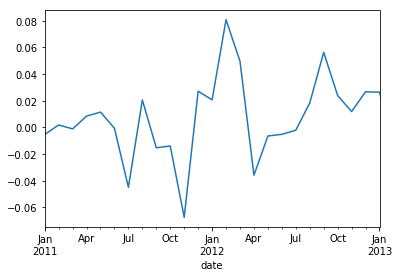

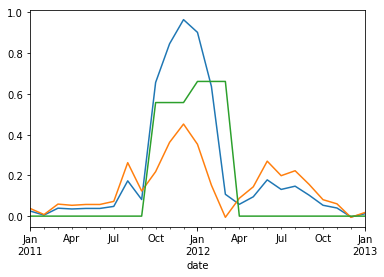

(468, 540)

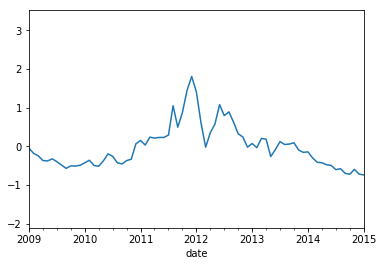

In [570]:
bond_return_index.resample('M').mean().pct_change()['ITA'].plot()
plt.xlim('2011-01','2013-01')
plt.show()
signals["ITA"].loc['2011-01':'2013-01'].plot()
CH_signals["ITA"].loc['2011-01':'2013-01'].plot()
GDP_signals["ITA"].loc['2011-01':'2013-01'].plot()
plt.show()
standardized_CH['ITA'].plot()
plt.xlim('2009-01','2015-01')

In [ ]:
bond_monthly_returns = bond_return_index.resample('M').mean().pct_change() - rf_rate_matrix_monthly
lagged_returns = bond_monthly_returns.shift(-1)
    
sig_returns = (lagged_returns * signals)
cum_sig_returns = (1+sig_returns).cumprod()
sig_pct = (cum_sig_returns-1)*100

for country in country_codes:
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(sig_returns[country].rolling(12).mean().dropna()
             .to_timestamp(), color='magenta', label = 'Bond Returns')
    ax1.set_ylabel('Bond Returns')
    ax1.legend(loc=2)
    ax2.plot(signals[country].to_timestamp().rolling(12).mean()
         ,color='crimson', label = 'Trading Signal')
    ax2.set_ylabel('Trading Signal')
    ax2.legend(loc='best')
    plt.title(country + " Returns vs. Signal")

In [805]:
curr_acct = dl.pull("CurrAcctPctGDP")
curr_acct_chg = curr_acct.pct_change()

In [816]:
rolling_ca_avg = curr_acct_chg.rolling(60).mean()
rolling_ca_std = curr_acct_chg.rolling(60).std()
standardized_ca = (curr_acct-rolling_ca_avg)/rolling_ca_std

In [821]:
ca_signal = (-1*standardized_ca).rolling(12).mean().clip(-1,1)

In [823]:
sharpe_ratio(ca_signal)

country
AUS        0.637119
DEU       -0.923356
CAN        0.430238
ESP       -0.563926
FRA        0.852967
ITA       -0.134884
JPN       -0.373189
CHE       -0.525046
GBR        0.683852
USA        0.489632
AVERAGE    0.057341
dtype: float64

In [960]:
curr_acct

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
1980Q1,-0.963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.572,-0.496
1980Q2,-1.720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.814,-0.135
1980Q3,-3.787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.163,0.607
1980Q4,-3.218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.205,0.319
1981Q1,-2.825,NaN,-4.141,NaN,NaN,NaN,NaN,NaN,3.822,0.123
1981Q2,-4.174,NaN,-4.626,NaN,NaN,NaN,NaN,NaN,1.970,0.155
1981Q3,-4.061,NaN,-4.670,NaN,NaN,NaN,NaN,NaN,-0.228,0.255
1981Q4,-5.330,NaN,-3.297,NaN,NaN,NaN,NaN,NaN,0.688,0.093
1982Q1,-5.397,NaN,-0.446,NaN,NaN,NaN,NaN,NaN,1.134,-0.035


In [961]:
stock_chg = curr_acct.pct_change()
global_avg_chg = stock_chg.rolling(6).mean().mean(axis=1)

stock_chg = stock_chg.sub(global_avg_chg, axis=0)
rolling_stock_avg = stock_chg.rolling(84).mean()
rolling_stock_std = stock_chg.rolling(84).std()
standardized_stock= (rolling_stock_avg-stock_chg)/rolling_stock_std

In [962]:
stock_signals = standardized_stock.divide(2).clip(-1,1).rolling(6).mean()
sharpe_ratio(stock_signals)

country
AUS       -0.364404
DEU       -0.428197
CAN        0.335502
ESP        0.834723
FRA       -0.113213
ITA        0.586712
JPN       -0.477188
CHE        0.181685
GBR       -0.525457
USA       -0.316632
AVERAGE   -0.028647
dtype: float64

In [958]:
stock_chg

country,AUS,CAN,CHE,DEU,ESP,FRA,GBR,ITA,JPN,USA
date,,,,,,,,,,
1980-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-07,NaN,NaN,NaN,0.006206,NaN,NaN,0.020780,NaN,NaN,0.058441
1980-08,NaN,NaN,NaN,0.001297,NaN,NaN,0.021520,NaN,NaN,0.085251
1980-09,NaN,NaN,NaN,0.003932,NaN,NaN,0.005471,NaN,NaN,0.024275
